In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
from fastai.vision.all import *
import pandas as pd
import cam
import util

In [3]:
# Use small bs as we have very limited data due to conditional hierarchy filtering
dls, labels = util.chexpert_data_loader(use_hierarchy=True, bs=4)

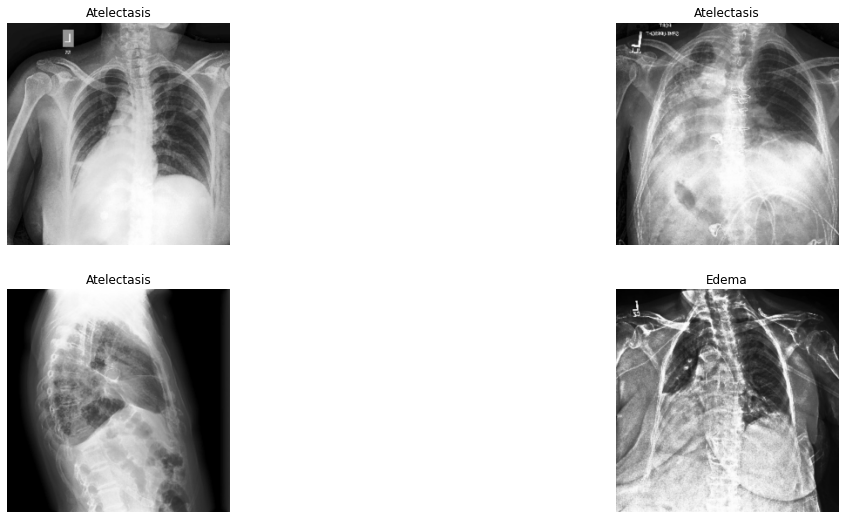

In [4]:
dls.show_batch(max_n=9, figsize=(20,9))

In [5]:
# First train on conditional probabilities
chexpert_learner_conditional = util.ChexpertLearner(dls, densenet121, n_out=len(labels),
                                        loss_func=BCEWithLogitsLossFlat(),
                                        metrics=[RocAucMulti(average=None),
                                                 RocAucMulti(average='weighted')])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/user/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


lr_min/10: 0.00036307806149125097, lr_steep: 9.12010818865383e-07, base_lr: 0.00036307806149125097


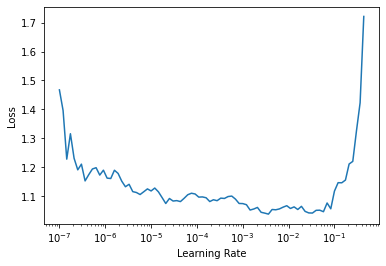

In [6]:
chexpert_learner_conditional.find_lr()

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.864928,0.645332,[0.6965812 0.67957607 0.5759382 0.63274055],0.650723,01:03


Better model found at epoch 0 with valid_loss value: 0.6453317403793335.


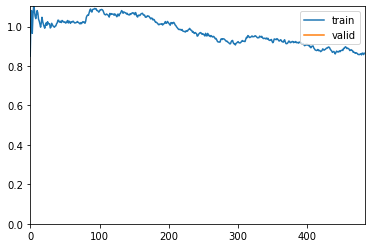

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.791312,0.621499,[0.66501241 0.70326927 0.59795633 0.64113828],0.659662,01:14
1,0.802711,0.609391,[0.67697822 0.71832226 0.58192932 0.66822801],0.673979,01:11
2,0.688517,0.577010,[0.66876206 0.72216634 0.58886321 0.65301154],0.669520,01:12
3,0.700777,0.569944,[0.681941 0.7308245 0.59318168 0.64621926],0.672806,01:11
4,0.680745,0.564326,[0.69944858 0.74584157 0.58183809 0.63028827],0.673423,01:11
5,0.677076,0.555852,[0.69713262 0.74691935 0.57067697 0.65601073],0.680922,01:12
6,0.662895,0.554812,[0.67667494 0.75613436 0.60826592 0.63245828],0.677735,01:13
7,0.648471,0.558615,[0.65809209 0.73386025 0.62140381 0.63457535],0.669860,01:11
8,0.613563,0.546593,[0.6851668 0.72710616 0.61909251 0.64351999],0.674883,01:14
9,0.603392,0.558719,[0.66859664 0.70700557 0.62070434 0.67070675],0.675301,01:12


Better model found at epoch 0 with valid_loss value: 0.6214989423751831.


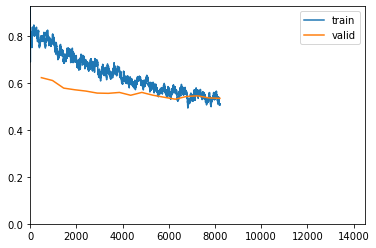

Better model found at epoch 1 with valid_loss value: 0.6093912124633789.
Better model found at epoch 2 with valid_loss value: 0.5770100951194763.
Better model found at epoch 3 with valid_loss value: 0.5699437856674194.
Better model found at epoch 4 with valid_loss value: 0.5643260478973389.
Better model found at epoch 5 with valid_loss value: 0.5558519959449768.
Better model found at epoch 6 with valid_loss value: 0.5548117160797119.
Better model found at epoch 8 with valid_loss value: 0.5465927720069885.
Epoch 10: reducing lr to 1.775147200885055e-05
Better model found at epoch 11 with valid_loss value: 0.5381374955177307.
Better model found at epoch 12 with valid_loss value: 0.5298285484313965.
Epoch 14: reducing lr to 1.4738570468794453e-05
Epoch 16: reducing lr to 1.23958092902866e-05
No improvement since epoch 12: early stopping


In [7]:
chexpert_learner_conditional.learn_model(use_saved=False, epochs=30)

/home/user/anaconda3/envs/fastai/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


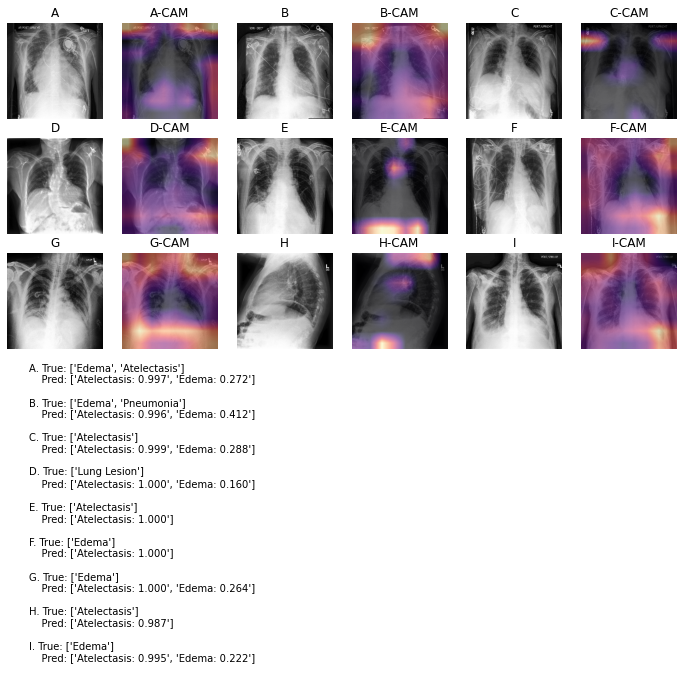

In [8]:
# Let us see how the conditional model predicts - use the saved optimal model
chexpert_learner = cnn_learner(dls, densenet121, path=Path('../saves/'))
chexpert_learner.load('densenet121-chexpert', with_opt=True)
cam.plot_cam(chexpert_learner)

In [9]:
# Reload the data as it may have been modified for conditional probs
dls, labels = util.chexpert_data_loader()

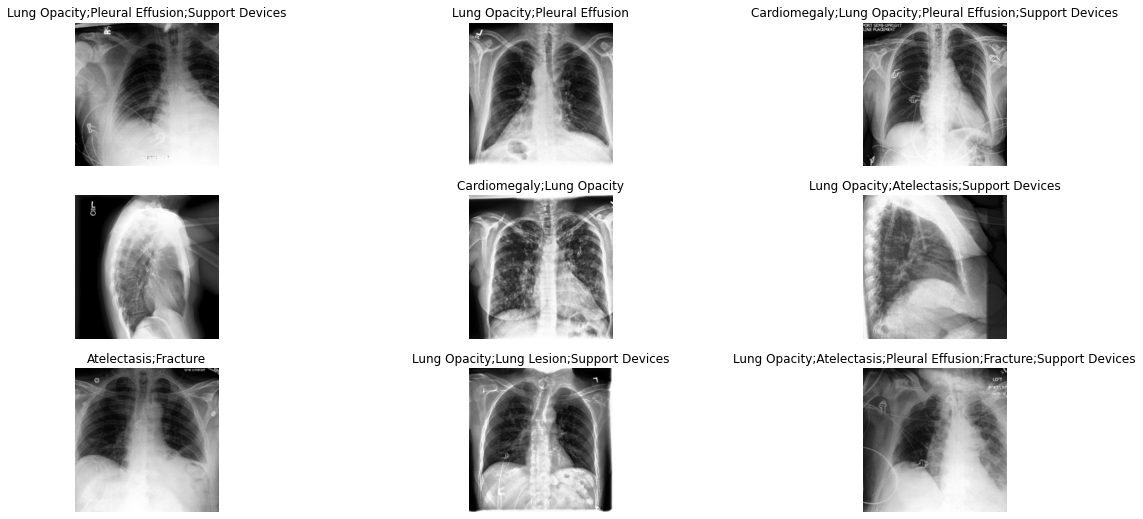

In [10]:
dls.show_batch(max_n=9, figsize=(20,9))

In [11]:
# Next train unconditionally for only transfer learning
chexpert_learner_unconditional = util.ChexpertLearner(dls, densenet121, n_out=len(labels),
                                        loss_func=BCEWithLogitsLossFlat(),
                                        metrics=[RocAucMulti(average=None),
                                                 RocAucMulti(average='weighted')])

lr_min/10: 0.017378008365631102, lr_steep: 0.03981071710586548, base_lr: 0.03981071710586548


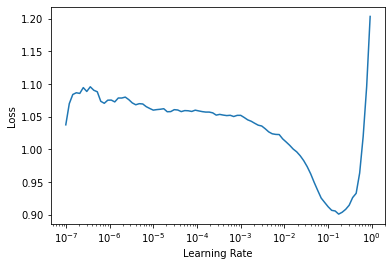

In [12]:
chexpert_learner_unconditional.find_lr()

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.302835,0.292994,[0.86569021 0.63175421 0.80810281 0.71794137 0.72887399 0.83148611 0.69369011 0.70716696 0.67337917 0.81264795 0.85615424 0.77476407 0.68487983 0.84027699],0.789200,16:24
1,0.291380,0.284943,[0.87502527 0.6551634 0.83240481 0.72693299 0.73768576 0.84012522 0.70598197 0.73179818 0.68500939 0.83237722 0.86851181 0.77681379 0.70541811 0.85932669],0.803119,16:13
2,0.289502,0.282311,[0.877274 0.66128863 0.84087947 0.72993898 0.74755804 0.84331114 0.71701016 0.7374843 0.6909905 0.84409672 0.87242011 0.78180987 0.71005674 0.86534637],0.808233,16:12
3,0.287853,0.281670,[0.87755035 0.65461154 0.84416231 0.72886622 0.74518202 0.84140447 0.71606603 0.73881332 0.68760088 0.84544975 0.87126582 0.7829755 0.72380539 0.8675166 ],0.808195,16:15
4,0.295703,0.280787,[0.87911577 0.65979913 0.84437755 0.72947922 0.74758246 0.84303223 0.71723198 0.73244174 0.68927752 0.85008297 0.87419087 0.78931519 0.71324783 0.87202443],0.810311,16:18
5,0.292306,0.285505,[0.87809543 0.64301316 0.84086625 0.73025273 0.75007964 0.83748515 0.70951733 0.7292621 0.67599847 0.84663902 0.87430512 0.75782278 0.70068986 0.8744612 ],0.808258,16:16
6,0.292767,0.286647,[0.87476865 0.64725295 0.84253571 0.72557647 0.7443698 0.84182661 0.71646639 0.72326064 0.68563889 0.83916261 0.87182693 0.77898593 0.71051791 0.87444318],0.808038,16:14
7,0.292872,0.287598,[0.87572883 0.65335861 0.84636484 0.7231207 0.74564752 0.84389927 0.711053 0.6809126 0.66305017 0.85110099 0.86774474 0.77260789 0.70976661 0.87050691],0.804851,16:11
8,0.296694,0.297031,[0.8780397 0.6587004 0.84345406 0.72267859 0.72564394 0.83973234 0.70042883 0.72349886 0.66961907 0.84913691 0.87276929 0.76578408 0.70944992 0.87278513],0.805901,16:11
9,0.300329,0.308033,[0.87772356 0.60667882 0.82902466 0.71896192 0.72846125 0.83648503 0.70030598 0.70051806 0.67839605 0.83303288 0.871416 0.75429134 0.68003457 0.8692277 ],0.801046,16:12


Better model found at epoch 0 with valid_loss value: 0.29299449920654297.


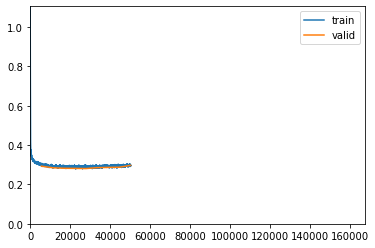

Better model found at epoch 1 with valid_loss value: 0.28494343161582947.
Better model found at epoch 2 with valid_loss value: 0.28231117129325867.
Better model found at epoch 3 with valid_loss value: 0.28166961669921875.
Better model found at epoch 4 with valid_loss value: 0.2807871997356415.
Epoch 6: reducing lr to 0.0006595532689677396
Epoch 8: reducing lr to 0.0009616887812421926
No improvement since epoch 4: early stopping


<IPython.core.display.Javascript object>

In [13]:
%%notify

# Freeze the body and update the weights for the last layer
chexpert_learner_unconditional.learn_model(use_saved=True, train_saved=True, old_learner=chexpert_learner_conditional.learn, epochs=0, freeze_epochs=30)

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.292521,0.283393,[0.87674522 0.64542645 0.83334496 0.73257639 0.74280583 0.83830253 0.71257585 0.72794402 0.68776424 0.84748517 0.87623337 0.78206206 0.70339462 0.88279806],0.811557,20:09
1,0.292632,0.280831,[0.87705957 0.65081756 0.84703554 0.73695056 0.75894761 0.83899047 0.70908271 0.72803254 0.69176406 0.8676573 0.87801451 0.78684884 0.72243228 0.88546321],0.815840,20:16
2,0.295738,0.281047,[0.87923829 0.66502988 0.84987707 0.73456978 0.75356481 0.83677262 0.71831988 0.72478912 0.69296255 0.86031396 0.8752699 0.78698937 0.71690873 0.88477094],0.814902,20:16
3,0.298114,0.348620,[0.86793857 0.63098816 0.83030513 0.72403551 0.74475971 0.83522303 0.70438283 0.71648985 0.68704269 0.85465085 0.86915736 0.74496283 0.67941483 0.88282448],0.806677,20:17
4,0.296734,0.319882,[0.86449232 0.62057218 0.84148344 0.72533979 0.76201639 0.83057412 0.71186891 0.72643184 0.67171543 0.85152778 0.87060799 0.77066209 0.68832589 0.88171917],0.806528,20:19
5,0.300146,0.372202,[0.86100051 0.61170614 0.83490444 0.72010868 0.74339168 0.83549892 0.69884517 0.67531479 0.67841122 0.84272528 0.86951625 0.69373829 0.69019955 0.87588752],0.802123,20:08
6,0.303589,0.356500,[0.87491013 0.60545415 0.83659115 0.72257582 0.74389038 0.82058785 0.71342242 0.69234634 0.6786628 0.85743795 0.86722119 0.74563429 0.70042531 0.87414172],0.802639,20:12


Better model found at epoch 0 with valid_loss value: 0.28339290618896484.


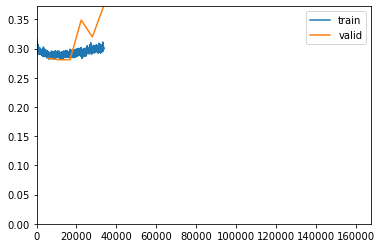

Better model found at epoch 1 with valid_loss value: 0.28083083033561707.
Epoch 3: reducing lr to 0.0010560113112227194
Epoch 5: reducing lr to 0.001592385600706532
No improvement since epoch 1: early stopping


<IPython.core.display.Javascript object>

In [14]:
%%notify

# Unfreeze the body and update the whole model end-to-end
chexpert_learner_unconditional.learn_model(use_saved=True, train_saved=True, epochs=30, freeze_epochs=0)

/home/user/anaconda3/envs/fastai/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


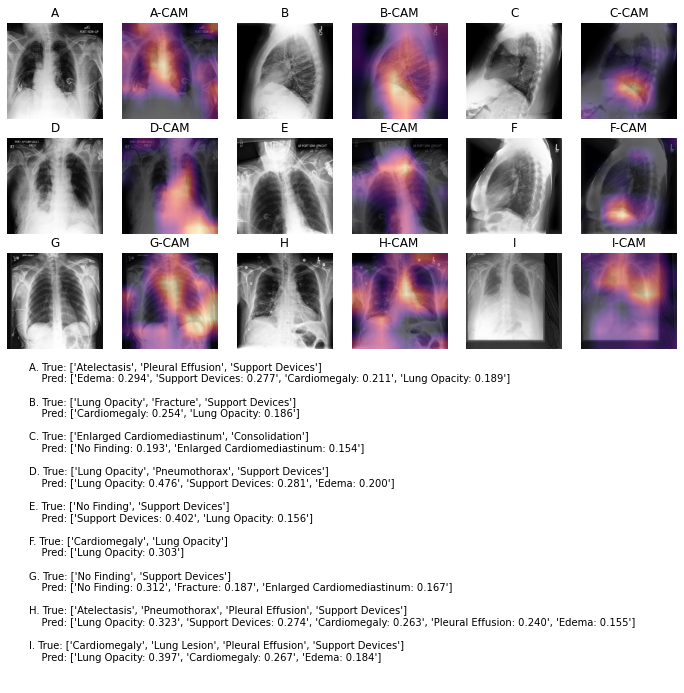

In [15]:
chexpert_learner = cnn_learner(dls, densenet121, path=Path('../saves/'))
chexpert_learner.load('densenet121-chexpert', with_opt=True)
cam.plot_cam(chexpert_learner)

In [16]:
chexpert_learner_unconditional.learn.save('densenet121-chexpert-final')

Path('../saves/models/densenet121-chexpert-final.pth.pth')